[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - A Feedforward Spiking Neural Network
## 튜토리얼 3
### 강의 [Jason K. Eshraghian](https://www.ncg.ucsc.edu)
### 번역 [ToToKr](https://github.com/moerai)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_3_feedforward_snn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


snnTorch 튜토리얼 시리즈는 다음 문서를 기반으로 합니다. 이러한 리소스나 코드가 작업에 유용하다고 생각되면 다음 소스를 인용해 주세요:


> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

# Introduction
이번 튜토리얼에서 당신은:
* leaky integrate-and-fire (LIF) 뉴런을 단순화하여 딥 러닝 친화적으로 만든느 방법을 알아보고
* spiking neural network (SNN)의 feedforward를 구현합니다.

다음 셀을 클릭하고 `Shift+Enter`를 눌러 최신 PyPi 배포판의 snnTorch를 설치합니다.

In [1]:
!pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# 1. Simplifying the Leaky Integrate-and-Fire Neuron Model
이전 튜토리얼에서 우리는 자체 LIF 뉴런 모델을 설계했습니다. 하지만 이는 상당히 복잡했고 $R$, $C$, $\Delta t$, $U_{\rm thr}$, 리셋 메커니즘 선택 등 조정해야 되는 하이퍼파라미터 배열이 많이 있었습니다. 이는 모델을 설계 할 때 관리해야 할 것이 많다는 의미이며, 본격적인 SNN으로 확장하면 더욱 번거로워집니다. 따라서 몇 가지를 단순화해 보겠습니다.

* [역자의 말] 해당 번역에서는 membrane potential을 막 전위로 번역했으며, membrane은 종종 멤브레인으로 번역하였음을 알려드립니다.

## 1.1 The Decay Rate: $\beta$

이전 튜토리얼에서는 오일러 방법을 사용하여 패시브 멤브레인(Passive membrane) 모델에 대한 다음 해를 도출했습니다:

$$U(t+\Delta t) = (1-\frac{\Delta t}{\tau})U(t) + \frac{\Delta t}{\tau} I_{\rm in}(t)R \tag{1}$$

이제 입력 전류가 없다고 가정합니다, $I_{\rm in}(t)=0 A$:

$$U(t+\Delta t) = (1-\frac{\Delta t}{\tau})U(t) \tag{2}$$

후속 값인 $U$의 비율, 즉 $U(t+\Delta t)/U(t)$를 막 전위(membrane potential)의 감쇠율이라고 합니다. 그리고 이는 역 시간 상수(inverse time constant)라고도 부릅니다:

$$U(t+\Delta t) = \beta U(t) \tag{3}$$

$(3)$에서 $ \beta $는 다음을 의미합니다:

$$\beta = (1-\frac{\Delta t}{\tau}) \tag{4}$$

합리적인 정확성을 위해, $\Delta t << \tau$ 입니다.

* [역자의 말] 일부 물리학에서는 드물지만 '$ < $'부등호를 강조하기위해 '$ << $'나 '$ <<< $'를 사용하기도 합니다.

## 1.2 Weighted Input Current
$t$ 가 연속적인 시간이 아닌 시퀀스의 Time step을 나타낸다고 가정하면, $\Delta t = 1$ 로 설정할 수 있습니다. 하이퍼파라미터의 수를 더 줄이려면 $R=1$ 이라고 가정하면 됩니다. $(4)$ 에서 가정은 이렇게 이어집니다:

$$\beta = (1-\frac{1}{C}) \implies (1-\beta)I_{\rm in} = \frac{1}{\tau}I_{\rm in} \tag{5}$$

입력 전류에는 $(1-\beta)$ 의 가중치가 적용됩니다.
추가로 입력 전류가 막 전위에 순간적으로 기여한다고 가정합니다:

$$U[t+1] = \beta U[t] + (1-\beta)I_{\rm in}[t+1] \tag{6}$$

시간을 이산화한다는 것은 각 시간 구간 $t$ 가 충분히 짧아서 뉴런이 이 구간에서 최대 한 번의 스파이크만 방출할 수 있다고 가정한다는 것을 의미합니다.

딥러닝에서 입력의 가중치는 종종 학습 가능한 파라미터입니다. 지금까지 물리적으로 실행 가능한 가정에서 한 걸음 더 나아가, $(6)$에서 $(1-\beta)$의 효과를 학습가능한 가중치 $W$에 포함시키고, 그에 따라 $I_{\rm in}[t]$를 input $X[t]$로 치환합니다:

$$WX[t] = I_{\rm in}[t] \tag{7}$$

이는 다음과 같이 해석할 수 있습니다. $X[t]$ 는 입력 전압 또는 스파이크이며, 뉴런에 전류 주입을 생성하기 위해 $W$ 의 시냅스 전도도에 따라 스케일링됩니다. 이렇게 하면 다음과 같은 결과가 나옵니다:

$$U[t+1] = \beta U[t] + WX[t+1] \tag{8}$$


향후 시뮬레이션에서는 $\beta$가 $W$에 미치는 영향이 분리됩니다. 즉, $W$는 학습 가능한 파라미터로 $\beta$와 독립적으로 업데이트 됩니다.


## 1.3 Spiking and Reset
이제 스파이크와 리셋 메커니즘을 소개합니다. 멤브레인이 임계값을 초과하면 뉴런이 출력 스파이크를 방출한다는 것을 기억하세요:

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{9}$$

스파이크가 트리거되면 막 전위가 재설정되어야 합니다.

*reset-by-subtraction* 메커니즘은 다음과 같이 모델링됩니다:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{S[t]U_{\rm thr}}_\text{reset} \tag{10}$$

$W$는 학습 가능한 파라미터이고 $U_{\rm thr}$는 보통 $1$로 설정되므로(조정 가능), 감쇠율 $\beta$만 지정할 하이퍼파라미터로 남게 됩니다. 이것으로 튜토리얼의 어려운 부분이 끝났습니다.

> 참고: 일부 구현은 약간 다른 가정을 할 수 있습니다. 예를 들어 $(9)$의 $S[t] \rightarrow S[t+1]$ 또는 $(10)$의 $X[t] \rightarrow X[t+1]$가 있습니다. 위 식의 도출은 성능의 변화 없이 순환 신경망 표현에 직관적으로 매핑되는 것을 발견했기 때문에 snnTorch에서 사용됩니다.

## 1.4 Code Implementation
파이썬에서 이 뉴런을 구현하면 다음과 같습니다:

In [4]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

$\beta$를 설정하려면 방정식 $(3)$을 사용하여 정의하거나 직접 하드코딩할 수 있습니다. 여기서는 데모를 위해 $(3)$을 사용하지만, 앞으로는 생물학적 정밀도보다는 작동하는 것에 더 초점을 맞추기 때문에 하드 코딩을 하게 될 것입니다.

방정식 $(3)$은 $\beta$가 두 개의 후속 time step에 걸친 막 전위의 비율임을 알려줍니다. [Tutorial 2](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 도출한 연속 시간 의존형 방정식(전류 주입이 없다고 가정)을 사용하여 이 방정식을 풀 수 있습니다:

$$U(t) = U_0e^{-\frac{t}{\tau}}$$

$U_0$은 $t=0$에서의 초기 막 전위 입니다. 시간 의존(time-dependent) 방정식이 $t, (t+\Delta t), (t+2\Delta t)~...~$의 이산 단계로 계산된다고 가정하면, 다음 step을 사용하여 후속 단계 사이의 막 전위의 비율을 구할 수 있습니다:

$$\beta = \frac{U_0e^{-\frac{t+\Delta t}{\tau}}}{U_0e^{-\frac{t}{\tau}}} = \frac{U_0e^{-\frac{t + 2\Delta t}{\tau}}}{U_0e^{-\frac{t+\Delta t}{\tau}}} =~~...$$
$$\implies \beta = e^{-\frac{\Delta t}{\tau}} $$


In [5]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


빠른 시뮬레이션을 실행하여 단계 전압 입력에 따라 뉴런이 올바르게 작동하는지 확인합니다:

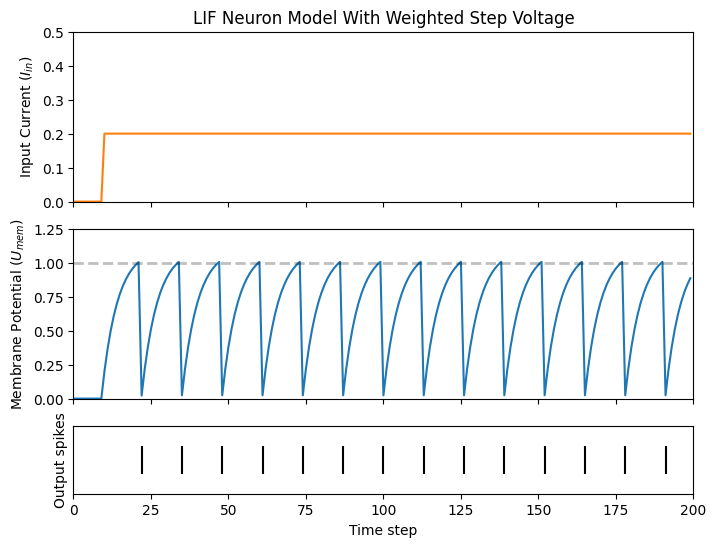

In [6]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

# 2. `Leaky` Neuron Model in snnTorch

이전 튜토리얼에서 `snn.Lapicque`를 사용한 것과 비슷한 방식으로 `snn.Leaky`를 인스턴스화하면 거의 동일한 뉴런을 얻을 수 있습니다. 하지만 하이퍼파라미터가 더 적습니다:



In [7]:
lif1 = snn.Leaky(beta=0.8)

이제 뉴런 모델이 `lif1` 변수에 저장됩니다. 이 뉴런을 사용하려면:

**Inputs**
* `cur_in`: $W\times X[t]$의 각 요소는 순차적으로 input으로 전달 됨
* `mem`: 이전 step 막 전위인 $U[t-1]$도 input으로 전달 됨

**Outputs**
* `spk_out`: output 스파이크 $S[t]$ ( 스파이크가 있는 경우 '1' 없는 경우 '0')
* `mem`: 현재 step의 막 전위 $U[t]$

이들은 모두 `torch.Tensor` 유형이어야 합니다. 여기서는 입력 전류가 `snn.Leaky` 뉴런으로 전달되기 전에 이미 가중치가 적용되었다고 가정합니다. 이는 네트워크 규모 모델을 구성할 때 더 의미가 있습니다. 또한 방정식 $(10)$은 일반성을 잃지 않고 한 단계 뒤로 시간 이동되었습니다.

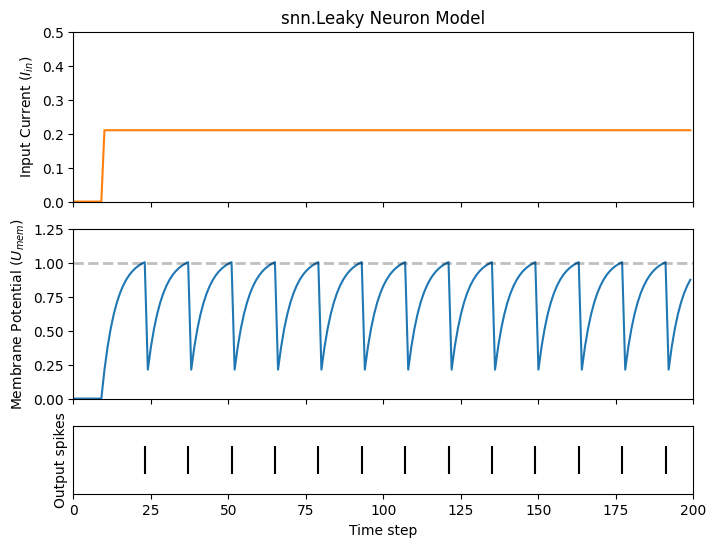

In [8]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

이 플롯을 수동으로 도출한 leaky integrate-and-fire 뉴런과 비교해봅시다. 막 전위 재설정은 *soft reset*을 사용하여 약간 더 약합니다. 이는 일부 딥 러닝 벤치마크에서 더 나은 성능을 제공하기 위해 의도적으로 수행되었습니다. 대신 사용되는 방정식은 다음과 같습니다:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{\beta S[t]U_{\rm thr}}_\text{soft reset} \tag{11}$$


이 모델에는 Lapicque의 뉴런 모델에 대해 설명한 것과 동일한 선택적 입력 인수인 `reset_mechanism`과 `threshold`가 있습니다.

# 3. A Feedforward Spiking Neural Network

지금까지는 단일 뉴런이 입력 자극에 반응하는 방식만 고려했습니다. snnTorch를 사용하면 이를 심층 신경망으로 간단하게 확장할 수 있습니다. 이 섹션에서는 784-1000-10 크기의 3계층 완전 연결 신경망을 만들어 보겠습니다. 지금까지의 시뮬레이션과 비교하여 이제 각 뉴런은 더 많은 입력 스파이크에 대해 통합됩니다.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

뉴런 사이의 연결을 형성하는 데는 PyTorch를 사용하고 뉴런을 생성하는 데는 snnTorch를 사용합니다. 먼저 모든 레이어를 초기화합니다.

In [9]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

다음으로 각 스파이크 뉴런의 숨겨진 변수와 출력을 초기화합니다.
네트워크의 크기가 커질수록 이 작업은 더 번거로워집니다(more tedious). 정적 메서드 `init_leaky()`를 사용하여 이 작업을 처리할 수 있습니다. snnTorch의 모든 뉴런은 동일한 구문을 따르는 자체 초기화 메서드(예: `init_lapicque()`)를 가지고 있습니다. Hiden state의 모양은 첫 번째 포워드 패스 동안 입력 데이터 차원에 따라 자동으로 초기화됩니다.

In [10]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

네트워크에 전달할 입력 스파이크 트레이닝을 생성합니다. 784개의 입력 뉴런에 걸쳐 시뮬레이션할 200개의 time step 즉, 입력은 $200 \times 784$차원을 갖습니다. 그러나 신경망은 일반적으로 데이터를 미니배치 단위로 처리합니다. snnTorch는 시간 우선 차원을 사용합니다:

[$time \times batch\_size \times feature\_dimensions$]

따라서 `dim=1`을 따라 입력을 'unsqueeze'하여 데이터의 '한 개의 배치'를 나타냅니다. 이 입력 텐서의 차원은 '200 $\times$ 1 $\times$ 784' 여야 합니다:

In [11]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


이제 드디어 전체 시뮬레이션을 실행할 차례입니다.

pyTorch와 snnTorch가 어떻게 함께 작동하는지 이해하기 위한 방법은 Pytorch가 뉴런을 라우팅(route)하고 snnTorch가 결과를 스파이크 뉴런 모델에 로드해보는 것입니다. 네트워크를 코딩 측면에서 이러한 스파이킹 뉴런은 시간에 따라 변화하는 activation function처럼 취급할 수 있습니다.

다음은 현재 진행 상황을 순차적으로 설명한 내용입니다:

*  `spk_in`에서 $j^{th}$ 뉴런으로의 $i^{th}$ input은 `nn.Linear`에서 초기화된 파라미터에 의해 가중치가 부여됩니다: $X_{i} \times W_{ij}$
* 이렇게 하면 방정식 $(10)$에서 입력 전류 항이 생성되어 스파이크 뉴런의 $U[t+1]$에 기여 합니다.
* $U[t+1] > U_{\rm thr}$인 경우, 뉴런에서 스파이크가 발생(triggered)됩니다.
* 이 스파이크는 두 번째 레이어 가중치에 의해 가중치가 부여되며, 모든 입력, 가중치, 뉴런에 대해 위의 과정이 반복됩니다.
* 스파이크가 없으면, 시냅스 후 뉴런(post-synaptic neuron)에 아무것도 전달되지 않습니다.

지금까지의 시뮬레이션과 유일한 차이점은 이제 $W$를 직접 설정하는 대신 `nn.Linear`에서 생성한 가중치로 입력 전류의 스케일을 조정한다는 점입니다.

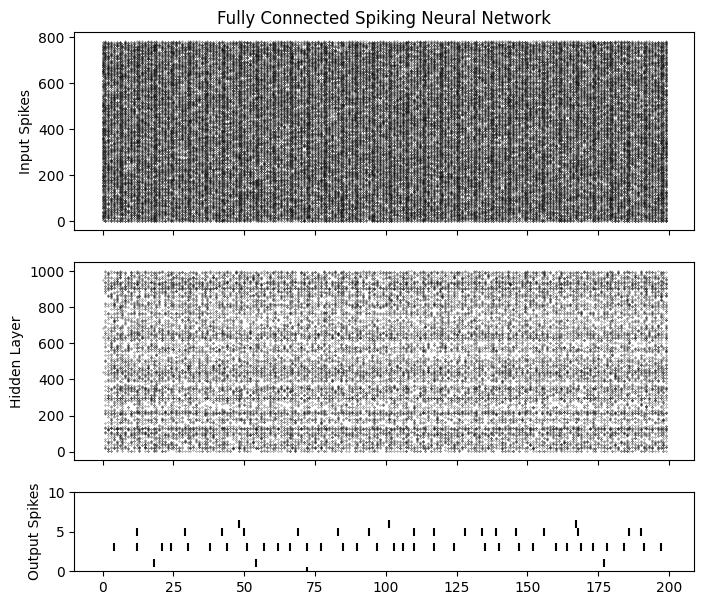

In [12]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

> 만약 오류가 발생하면 네트워크와 매개변수(parameter)를 다시 초기화해 보세요.


이 단계에서는 스파이크가 실제 의미를 갖지 않습니다. 입력과 가중치는 모두 무작위로 초기화되어 있으며 학습이 이루어지지 않았습니다. 그러나 스파이크는 첫 번째 레이어에서 출력까지 전파되는 것처럼 보여야 합니다. 스파이크가 보이지 않는다면 가중치 초기화 과정에서 운이 나빴을 수 있으므로 마지막 네 개의 코드 블록을 다시 실행해 보면 됩니다.

spikeplot.spike_count`는 output layer의 spike counter를 생성할 수 있습니다. 다음 애니메이션은 생성하는 데 다소 시간이 걸립니다.<br>

> 참고: 데스크톱에서 로컬로 노트북을 실행하는 경우, 아래 줄의 주석 처리를 해제하고 ffmpeg.exe의 경로를 수정하세요.

In [ ]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

spikeplot.traces`를 사용하면 막 전위 추적을 시각화할 수 있습니다. 출력 뉴런 10개 중 9개를 플롯하겠습니다.

위의 애니메이션 및 raster plot과 비교하여 뉴런의 흔적이 일치하는지 확인합니다.

In [ ]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)

일부 뉴런은 발화하는데 다른 뉴런은 완전히 죽어 있는 것은 지극히 정상적인 현상입니다. 다시 말하지만, 이러한 스파이크는 가중치가 훈련되기 전까지는 실제 의미가 없습니다.

# Conclusion

여기서는 leaky integrate-and-fire 뉴런 모델을 단순화한 다음 이를 사용해 스파이크 신경망을 구축하는 방법을 다룹니다. 실제로는 하이퍼파라미터 검색 공간이 더 작기 때문에 네트워크 훈련에 `snn.Lapicque`보다 `snn.Leaky`를 사용하는 것을 거의 항상 선호합니다.

[Tutorial 4](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서는 2nd-order `snn.Synaptic` 및 `snn.Alpha` 모델에 대해 자세히 설명합니다.
이 다음 튜토리얼(튜토리얼 4)은 네트워크 훈련에 필요하지 않으므로 snnTorch를 사용한 딥 러닝으로 바로 넘어가려면 [Tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)로 건너뛰세요.

참고로 문서는 [여기](https://snntorch.readthedocs.io/en/latest/snntorch.html)에서 확인할 수 있습니다.

이 프로젝트가 마음에 드신다면 GitHub에서 리포지토리의 ⭐(Star)를 눌러주세요.

## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan